In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import os 
import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import model_selection
from sklearn import metrics


SEED = 12345

## <a id='read'>Read Data</a>

In [2]:
def data_reader():
    """read data"""
    
    data_dir = os.path.join('..', 'data') 

    train_1day_path = os.path.join(data_dir, 'train_1day.csv')

    train_1day = pd.read_csv(train_1day_path)
    
    return train_1day

In [3]:
train_1day = data_reader()

In [4]:
train_1day.head()

,obs_id,SiteId,Timestamp,ForecastId,Value,Weekday,Date,Hour,minute_bin,ForecastPeriodNS,Holiday,OnAndOff,Surface,Sampling,BaseTemperature,isHoliday,Weather
0,744519,1,2014-09-03,1,9.096555e+05,2,2014-09-03,0,0,1day,NaN,False,1387.205119,15.0,18.0,False,20.752083
1,7627564,1,2014-09-04,1,1.748273e+06,3,2014-09-04,0,0,1day,NaN,False,1387.205119,15.0,18.0,False,22.418750
2,7034705,1,2014-09-05,1,1.748273e+06,4,2014-09-05,0,0,1day,NaN,False,1387.205119,15.0,18.0,False,25.734615
3,5995486,1,2014-09-06,1,1.748273e+06,5,2014-09-06,0,0,1day,NaN,True,1387.205119,15.0,18.0,False,19.635417
4,7326510,1,2014-09-07,1,1.748273e+06,6,2014-09-07,0,0,1day,NaN,True,1387.205119,15.0,18.0,False,17.133333


In [5]:
train_1day.shape

(52860, 17)

## <a id='transform'>Data Transformation</a>

In [6]:
def train_data_generator(train, response):
    """drop features | create dummies | create x & y"""
    
    
    # drop unneeded features
    drop_feature = ['obs_id', 'SiteId', 'Timestamp','ForecastId','Date','ForecastPeriodNS']
    train = train.drop(drop_feature, axis=1, inplace=False)
    
    # create dummy variables
    categorical = ['Holiday']    
    # Convert data type as 'category'
    for i in categorical:
        train[i] = train[i].astype('category')
        
    # Create dummy variables
    train_dummy = pd.get_dummies(train, columns = categorical)
    train_dummy.head()
    
    # map True/False in to 1/0
    train_dummy['OnAndOff'] = train_dummy['OnAndOff'].map({False: 0, True: 1})
    train_dummy['isHoliday'] = train_dummy['isHoliday'].map({False: 0, True: 1})    
    
    # drop NA weather
    train_dummy = train_dummy[train_dummy.Weather.notnull()]
    
    # Split data into response and predictors
    y = train_dummy[response]
    x = train_dummy.drop(response, axis=1)

    return x, y


In [7]:
x, y = train_data_generator(train_1day, 'Value')

In [8]:
x

,Weekday,Hour,minute_bin,OnAndOff,Surface,Sampling,BaseTemperature,isHoliday,Weather,Holiday_All Saints Day,...,Holiday_Veterans Day,Holiday_Victory in Europe Day,Holiday_Washington's Birthday,Holiday_West Virgina Day,Holiday_West Virgina Day (Observed),Holiday_Whit Monday,Holiday_Whit Sunday,Holiday_Workers Day,Holiday_Workers Day substitute,Holiday_Youth Day
0,2,0,0,0,1387.205119,15.0,18.0,0,20.752083,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,1387.205119,15.0,18.0,0,22.418750,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,1387.205119,15.0,18.0,0,25.734615,0,...,0,0,0,0,0,0,0,0,0,0
3,5,0,0,1,1387.205119,15.0,18.0,0,19.635417,0,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0,1,1387.205119,15.0,18.0,0,17.133333,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1387.205119,15.0,18.0,0,17.575000,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,0,0,1387.205119,15.0,18.0,0,19.697917,0,...,0,0,0,0,0,0,0,0,0,0
7,2,0,0,0,1387.205119,15.0,18.0,0,20.908333,0,...,0,0,0,0,0,0,0,0,0,0
8,3,0,0,0,1387.205119,15.0,18.0,0,15.360417,0,...,0,0,0,0,0,0,0,0,0,0
9,4,0,0,0,1387.205119,15.0,18.0,0,13.970408,0,...,0,0,0,0,0,0,0,0,0,0


## <a id='model'>Model Building</a>

In [9]:
def fit_randomforest(X_train, y_train, param_setting={}, fold=5, seed=SEED):
    """Random Forest for Classification, get the CV AUC"""

    # set seed and default parameter 
    params_default = {'random_state':seed}

    # update the input parameters
    params = dict(params_default)
    params.update(param_setting)
    
    # create model object
    model = RandomForestRegressor(**params)
    
    # do kfold cross validation and use auc as metrics
    kfold = model_selection.KFold(n_splits=fold, random_state=seed)    
    results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2') #
    print(results.mean())
    
    model.fit(X_train, y_train)
    
    return model, results

In [10]:
model_rf, results = fit_randomforest(x, y, fold=5, seed=SEED)

-18.2336669911


In [11]:
results

array([ -8.26589103e-01,  -8.43690813e+01,  -7.46511344e-04,
        -6.62162864e-01,  -5.30975515e+00])

In [12]:
model_rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=12345, verbose=0,
           warm_start=False)

## <a id='importance'>Feature Importance</a>

In [13]:
def get_variance_imp_df(model):
    """get the variance importance dataframe for tree based models"""
    
    var_imp = pd.DataFrame(x.columns, model.feature_importances_).reset_index().rename(columns={'index': 'importance',0:'feature'}).sort_values(by=['importance'], ascending=False)
    var_imp = var_imp[['feature','importance']].reset_index(drop=True)
    
    return(var_imp)

In [14]:
def viz_importance(var_imp, top):
    y_pos = np.arange(1, top + 1)
    plt.barh(y_pos, list(var_imp['importance'])[0:top][::-1], align = 'center')#, xerr = scores_std[0:top]
    plt.yticks(y_pos, var_imp['feature'][0:top][::-1])
    plt.xlabel('Importance')
    plt.title('Feature Importance Plot')   

In [15]:
rf_imp = get_variance_imp_df(model_rf)
rf_imp.head(15)

,feature,importance
0,Weather,0.899228
1,Surface,0.081875
2,BaseTemperature,0.012818
3,Sampling,0.002173
4,OnAndOff,0.001769
5,Weekday,0.001597
6,isHoliday,0.000299
7,minute_bin,0.000166
8,Holiday_Liberation Day,0.000015
9,Holiday_Assumption of Mary to Heaven,0.000014


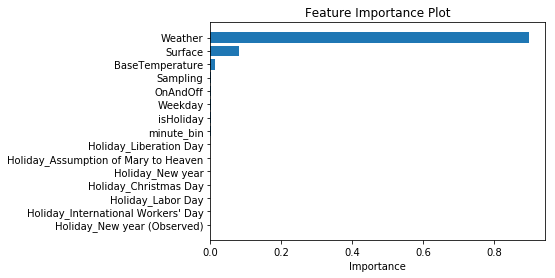

In [16]:
viz_importance(rf_imp, top=15)

In [17]:
y_true = [1,2,3]
y_pred = [3,2,1]
metrics.r2_score(y_true, y_pred)

-3.0

In [22]:
# train_1day.query('SiteId==1')['Value']

## <a id='refer'>Reference</a>
* [Scoring Metrics](http://scikit-learn.org/0.15/modules/model_evaluation.html)